# Load packages

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import plotly.io as pio

# Load Data

In [2]:
file_path = '/Users/tamasbarczikay/VScode_projects/python-xgboost-supervised/miami-housing.csv'
data = pd.read_csv(file_path)
data = data[['PARCELNO', 'SALE_PRC', 'age', 'structure_quality', 'CNTR_DIST', 'LND_SQFOOT', 'TOT_LVG_AREA']]

# Drop duplicates based on PARCELNO, keep the first occurrence
data = data.drop_duplicates(subset='PARCELNO', keep='first')

# Number of observations and data types
print(f'We have {data.shape[0]} observations after dropping duplicates.')

print("\nData Types:")
print(data.dtypes)

# Get baseline summary statistics
print("\nBaseline Summary Statistics:")
print(data.describe().round(1))

We have 13776 observations after dropping duplicates.

Data Types:
PARCELNO               int64
SALE_PRC             float64
age                    int64
structure_quality      int64
CNTR_DIST            float64
LND_SQFOOT             int64
TOT_LVG_AREA           int64
dtype: object

Baseline Summary Statistics:
           PARCELNO   SALE_PRC      age  structure_quality  CNTR_DIST  \
count  1.377600e+04    13776.0  13776.0            13776.0    13776.0   
mean   2.357748e+12   400746.4     30.6                3.5    68625.8   
std    1.198670e+12   317868.5     21.1                1.1    31990.8   
min    1.020008e+11    72000.0      0.0                1.0     3825.6   
25%    1.079160e+12   235000.0     14.0                2.0    42955.2   
50%    3.040305e+12   311100.0     26.0                4.0    66039.8   
75%    3.060180e+12   430000.0     46.0                4.0    89542.6   
max    3.660170e+12  2650000.0     96.0                5.0   159976.5   

       LND_SQFOOT  TOT_LVG_A

# EDA


Occurrences in structure_quality:
   structure_quality  count
3                  1    172
1                  2   4053
4                  3     16
0                  4   7546
2                  5   1989


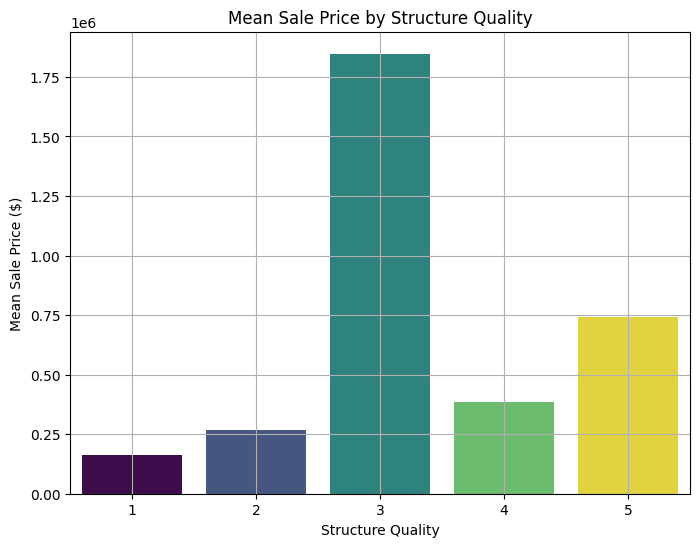

In [3]:
# Bar chart: Mean SALE_PRC by structure_quality (also count occurences)
structure_quality_counts = data['structure_quality'].value_counts().reset_index()
structure_quality_counts.columns = ['structure_quality', 'count']
structure_quality_counts = structure_quality_counts.sort_values(by='structure_quality')

print("\nOccurrences in structure_quality:")
print(structure_quality_counts)

mean_prices_by_quality = data.groupby('structure_quality')['SALE_PRC'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(
    x='structure_quality',
    y='SALE_PRC',
    data=mean_prices_by_quality,
    hue='structure_quality',
    palette='viridis',
    dodge=False,
    legend=False
)
plt.title('Mean Sale Price by Structure Quality')
plt.xlabel('Structure Quality')
plt.ylabel('Mean Sale Price ($)')
plt.grid(True)
plt.show()

# Create a new binary variable for superior quality
data['superior_quality'] = (data['structure_quality'] == 5).astype(int)

# XGBOOST - classification

Parameter Explanation

The following parameter grid is used for **XGBoost** hyperparameter tuning in a **binary classification task**. Each parameter has a specific role in controlling the model's behavior, particularly for optimizing predictive accuracy and generalization.

```python
param = {
    'objective': 'binary:logistic',  # Classification objective
    'eval_metric': 'logloss',       # Log loss for binary classification
    'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
    'max_depth': trial.suggest_int('max_depth', 3, 7),
    'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
    'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8]),
    'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
    'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
}
```

# Parameter Descriptions

## 1. `objective: 'binary:logistic'`
- **Purpose**: Sets the model's task as binary classification.
- **Output**: Probabilities for the two classes in the range [0, 1].
- **Usage**: A threshold (e.g., 0.5) is applied to convert probabilities into binary predictions.

## 2. `eval_metric: 'logloss'`
- **Purpose**: Specifies the evaluation metric as logarithmic loss.
- **Measurement**: Measures the model's predictive accuracy for probabilities.
- **Goal**: Lower values indicate better performance, particularly suitable for classification problems with probabilistic outputs.

## 3. `n_estimators`
- **Purpose**: Specifies the number of boosting rounds or trees.
- **Values**: `[100, 200, 300]`.
- **Effect**: A higher number of estimators reduces bias but may increase overfitting if not regularized.

## 4. `max_depth`
- **Purpose**: Defines the maximum depth of each decision tree.
- **Values**: `[3, 4, 5, 6, 7]`.
- **Effect**: Deeper trees capture more complex patterns but may overfit on small datasets.

## 5. `learning_rate`
- **Purpose**: Determines the step size for updating weights in each boosting round.
- **Values**: `[0.01, 0.05, 0.1, 0.2]`.
- **Effect**: Smaller values slow down learning, requiring more trees, but often lead to better generalization.

## 6. `subsample`
- **Purpose**: Controls the fraction of training data sampled for each tree.
- **Values**: `[0.6, 0.7, 0.8]`.
- **Effect**: Smaller values introduce more randomness, helping to prevent overfitting.

## 7. `reg_alpha`
- **Purpose**: L1 regularization term, penalizing the absolute values of leaf weights.
- **Values**: Continuous range `[0.01, 10.0]` (log-scaled).
- **Effect**: Encourages sparsity in the model, reducing the number of features used.

## 8. `reg_lambda`
- **Purpose**: L2 regularization term, penalizing the squared values of leaf weights.
- **Values**: Continuous range `[1.0, 10.0]`.
- **Effect**: Helps smooth the model and reduce overfitting by shrinking large weights.

Baseline Accuracy: 0.9303
Precision: 0.8297
Recall: 0.6441
F1-Score: 0.7252



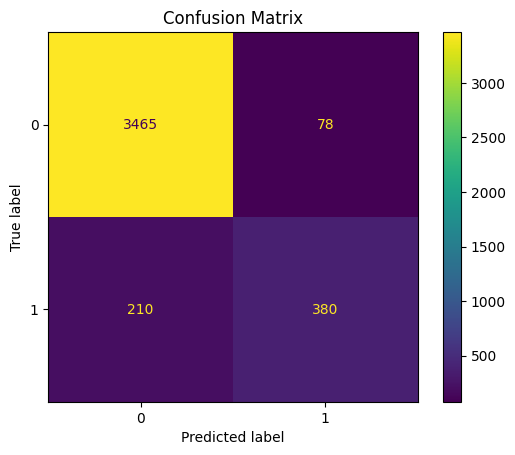

In [4]:
# Drop the original structure_quality column from features (plus additional)
X = data.drop(columns=['superior_quality', 'structure_quality', 'PARCELNO']) 
y = data['superior_quality']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize XGBoost
xgboost_classifier = xgb.XGBClassifier(
    objective='binary:logistic',  # Logistic regression objective
    n_estimators=100,             # Number of trees
    max_depth=6,                  # Tree depth
    learning_rate=0.1,            # Step size shrinkage
    random_state=42               # Reproducibility
)

# Train the classifier
xgboost_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = xgboost_classifier.predict(X_test)

# Evaluate model performance
accuracy = (y_test == y_pred).mean()
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print metrics
print(f"Baseline Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print()

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(xgboost_classifier, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

# XGBOOST classification with Hyperparameter Tuning

In [5]:
# Define the objective function for Optuna
def classification_objective(trial):
    # Define parameter grid
    param = {
        'objective': 'binary:logistic',  # Classification objective
        'eval_metric': 'logloss',       # Log loss for binary classification
        'n_estimators': trial.suggest_categorical('n_estimators', [100, 200, 300]),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.2]),
        'subsample': trial.suggest_categorical('subsample', [0.6, 0.7, 0.8]),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1.0, 10.0),
    }

    # Initialize XGBoost classifier
    model = xgb.XGBClassifier(**param)
    
    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    # Predict probabilities and evaluate with accuracy
    preds = model.predict(X_test)
    accuracy = (y_test == preds).mean()  # Accuracy as the optimization target
    return accuracy

# Run Optuna optimization to maximize accuracy
classification_study = optuna.create_study(direction='maximize')
classification_study.optimize(classification_objective, n_trials=20)

# Print the best hyperparameters
print("\nBest Hyperparameters:")
print(classification_study.best_params)

[I 2025-01-23 12:15:27,039] A new study created in memory with name: no-name-b6f874ab-345f-4d63-9505-f8fa518b7ceb
[I 2025-01-23 12:15:28,051] Trial 0 finished with value: 0.9245100411323494 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.8, 'reg_alpha': 0.4803934766061419, 'reg_lambda': 9.308527041975214}. Best is trial 0 with value: 0.9245100411323494.
[I 2025-01-23 12:15:28,608] Trial 1 finished with value: 0.9109605613355916 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.7, 'reg_alpha': 2.868081879243485, 'reg_lambda': 4.023944804870134}. Best is trial 0 with value: 0.9245100411323494.
[I 2025-01-23 12:15:29,120] Trial 2 finished with value: 0.9288652310670216 and parameters: {'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.05, 'subsample': 0.7, 'reg_alpha': 0.3710913880373762, 'reg_lambda': 2.8822911600296526}. Best is trial 2 with value: 0.9288652310670216.
[I 2025-01-23 12:15:30,053] 


Best Hyperparameters:
{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_alpha': 0.11680916738365131, 'reg_lambda': 4.936172401002745}



Final Model Metrics:
Accuracy: 0.9368
Precision: 0.8283
Recall: 0.7034
F1-Score: 0.7608



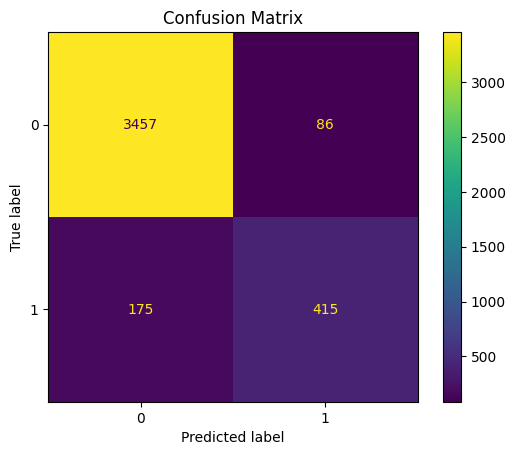

In [6]:
# Train the final model with optimized hyperparameters
optimized_classification_params = classification_study.best_params
optimized_classification_params['objective'] = 'binary:logistic'
optimized_classification_params['eval_metric'] = 'logloss'

final_classifier = xgb.XGBClassifier(**optimized_classification_params)
final_classifier.fit(X_train, y_train)

# Evaluate the final model
y_pred = final_classifier.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

# Print metrics
print(f"\nFinal Model Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print()

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(final_classifier, X_test, y_test)
plt.title("Confusion Matrix")
plt.show()

# Plot Feature Importances and Optimization Process

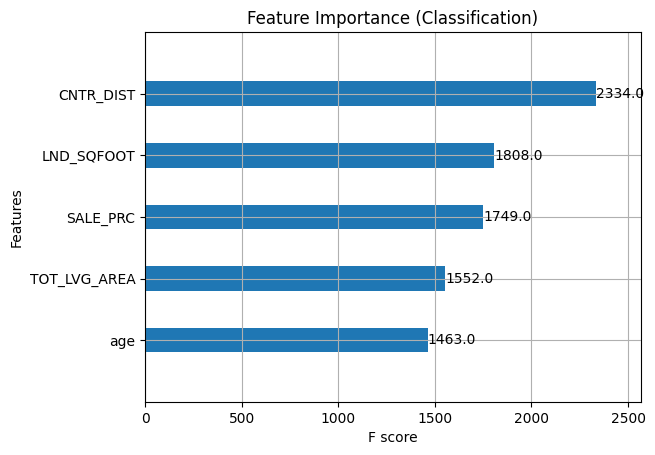

In [7]:
# Feature importance plot
xgb.plot_importance(final_classifier, importance_type='weight', max_num_features=10, height=0.4)
plt.title('Feature Importance (Classification)')
plt.show()

In [11]:
# Save optimization results as HTML
opt_hist = plot_optimization_history(classification_study)
opt_hist.write_html("classification_optimization_history.html")
print("Optimization history plot saved as 'classification_optimization_history.html'")
print()

param_imp = plot_param_importances(classification_study)
param_imp.write_html("classification_param_importances.html")
print("Parameter importances plot saved as 'classification_param_importances.html'")

Optimization history plot saved as 'classification_optimization_history.html'

Parameter importances plot saved as 'classification_param_importances.html'


In [15]:
# Display optimization history inline
opt_hist = plot_optimization_history(classification_study)
pio.show(opt_hist)  # Displays the interactive plot inline

# Display parameter importances inline
param_imp = plot_param_importances(classification_study)
pio.show(param_imp)  # Displays the interactive plot inline

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed